# Автоэнкодеры PyTorch

## Контекст

Нам предстоит поработать с автоэнкодерами:
- `Vanilla Autoencoder`
- `Variation Autoencoder (VAE)`
- `Conditional VAE`


# Импорт библиотек

Импортируем необходимые для работы в дальнейшем библиотеки. Для удобства соберем импорты в первой ячейке

In [ ]:
%%capture
!pip install catalyst

```
from get_dataset import fetch_dataset
```

In [ ]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils 
from torchvision import datasets, transforms
import plotly.express as px
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from skimage.transform import resize
from skimage.io import imread
import scipy.stats as stats
from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import warnings
from catalyst.utils import set_global_seed
from copy import deepcopy
from sklearn.preprocessing import QuantileTransformer
import plotly.express as px
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")
np.random.seed(42)
set_global_seed(42)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

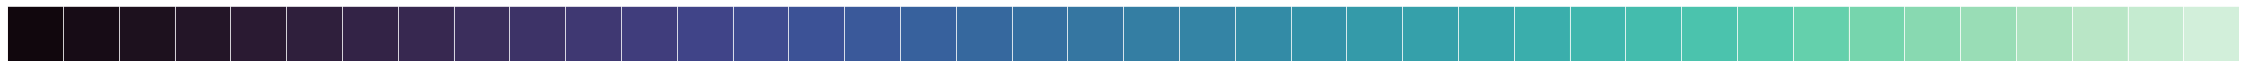

In [ ]:
current_palette = sns.color_palette('mako', 40)
sns.palplot(current_palette)

# Часть 1. Vanilla Autoencoder

**Автоэнкодеры** — это нейронные сети прямого распространения, которые восстанавливают входной сигнал на выходе. Внутри у них имеется скрытый слой, который представляет собой код, описывающий модель. **Автоэнкодеры** конструируются таким образом, чтобы не иметь возможность точно скопировать вход на выходе. Обычно их ограничивают в размерности кода (он меньше, чем размерность сигнала) или штрафуют за активации в коде. Входной сигнал восстанавливается с ошибками из-за потерь при кодировании, но, чтобы их минимизировать, сеть вынуждена учиться отбирать наиболее важные признаки. [Источник](https://habr.com/ru/post/331382/)

## 1.1. Подготовка данных

Прежде, чем приступать к построению простейшего Автоэнкодера - загрузим данные и подготовим сеты для обучения. Использовать будем датасет `"Labeled Faces in the Wild"` [LFW](http://vis-www.cs.umass.edu/lfw/)

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64, dimy=64
    ):
  
    """
    Функция для загрузки данных
    
    """

    # если данных нет - скачать
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    # прочитать атрибуты
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    # прочитать фото
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)
    all_attrs = df.drop(["photo_path", "person","imagenum"],axis=1)
    
    return all_photos, all_attrs

Функция готова, скачаем изображения и атрибуты, которые понадобятся нам в части генерации, например - найти улыбку и т.д.

In [ ]:
data, attrs = fetch_dataset()

Разобьем выборку картинок на `train` и `val` - и посмотрим на несколько

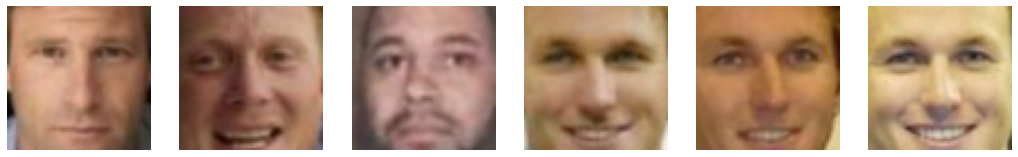

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(data[i])
plt.show();

In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
IN_CHANN = data.shape[3]

print(f'Загружено {data.shape[0]} изображений')
print(f'Высота {IMAGE_H}, Ширина {IMAGE_W}, каналов: {IN_CHANN}')

Загружено 13143 изображений
Высота 64, Ширина 64, каналов: 3


Как видим, загружено 13143 изображений с лицами, размер `64x64x3`. Разобьем нашу выборку на обучающую и валидационную - 20% пойдет на валидацию

In [ ]:
X_train, X_val, y_train, y_val = (train_test_split(data, attrs, 
                                                  test_size=.20, 
                                                  random_state=42,
                                                  shuffle=False
                                                  )
)

Наконец - приведем наши выборки к тензорам

In [ ]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

Данные загружены и подготовлены - можем приступать к построению простейшей архитектуры автоэнкодера

## 1.2. Архитектура модели 




<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">



Реализуем autoencoder - используем несколько линейных слоев и `Batchnorm1d` слоев. Также попробуем построить архитектуру с использованием сверточных слоев и посмотрим разницу. 

In [ ]:
dim_code = 16

Построим линейный автокодировщик и попробуем добавить на выходе `F.sigmoid`, чтобы получать значения `[0, 1]`

In [ ]:
class Autoencoder(nn.Module):


    def __init__(self):
        super().__init__()
        IMAGE_H = 64
        IMAGE_W = 64
        IN_CHANN = 3
        self.encoder = nn.Sequential(
            nn.Linear(IMAGE_H * IMAGE_W * IN_CHANN, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, dim_code),
            nn.BatchNorm1d(dim_code),

        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, IMAGE_H * IMAGE_W * IN_CHANN)
        )

    def sample(self, z):
        generated = self.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, IMAGE_H, IMAGE_W, IN_CHANN)
        return generated

    def encode(self,x):
        latent_code = self.encoder(x)
        return latent_code

    def decode(self, latent_code):
        reconstruction = self.decoder(latent_code)
        reconstruction = F.sigmoid(reconstruction) 
        return reconstruction


      
    def forward(self, x):
        latent_code = self.encoder(x) 
        reconstruction = self.decoder(latent_code)
        reconstruction = F.sigmoid(reconstruction)       
        return latent_code, reconstruction

Первая модель готова. Попробуем также использовать архитектуру со сверточными слоями и `F.sigmoid` на выходе, чтобы получать значения `[0, 1]`

In [ ]:
class Autoencoder_Conv(nn.Module):

    def __init__(self):
        super().__init__()
        IN_CHANN = 3
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=IN_CHANN, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=4, out_channels=16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=IN_CHANN, kernel_size=2, stride=2),

        )
    def encode(self,x):
        x = x.permute(0, 3, 1, 2)
        latent_code = self.encoder(x)
        return latent_code

    def decode(self, latent_code):
        reconstruction = self.decoder(latent_code)
        reconstruction = F.sigmoid(reconstruction)  
        return reconstruction
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        latent_code = self.encoder(x) 
        reconstruction = self.decoder(latent_code)
        reconstruction = F.sigmoid(reconstruction)  
        return latent_code, reconstruction

И попробуем еще одну архитектуру - в ней будет `Flatten` слой и `F.sigmoid` на выходе, чтобы получать значения `[0, 1]`. Также увеличим количество карт у изображений на свертках

In [ ]:
class Autoencoder_Conv_Flatten(nn.Module):

    def __init__(self):
        super().__init__()
        IN_CHANN = 3
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=IN_CHANN, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Flatten + линейный слой
            nn.Flatten(start_dim=1),
            nn.Linear(32 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, dim_code),

            )


        
        self.decoder = nn.Sequential(
            # линейный слой + Unflatten
            nn.Linear(dim_code, 512),
            nn.ReLU(),
            nn.Linear(512, 32 * 16 * 16),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(32, 16, 16)),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=IN_CHANN, kernel_size=2, stride=2)

        )

    def encode(self,x):
        x = x.permute(0, 3, 1, 2)
        latent_code = self.encoder(x)
        return latent_code

    def decode(self, latent_code):
        reconstruction = self.decoder(latent_code)
        reconstruction = F.sigmoid(reconstruction)  
        return reconstruction

        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        latent_code = self.encoder(x) 
        reconstruction = self.decoder(latent_code)
        reconstruction = F.sigmoid(reconstruction)
        return latent_code, reconstruction

Модели готовы. Можем приступать к написанию кода для обучения

## 1.3 Обучение 

Код для обучения будет состоять из 4 функций:

- `fit_epoch` - обучение модели на одной эпохе
- `eval_epoch` - проверка модели на валидационной выборке
- `draw_img` - вывод изображений с валидационной выборки - оригинал и восстановленная
- `train` - функция обучения, возвращает историю обучения. Является оберткой остальных функций

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, conv):

    """
    Функция для обучения модели на обучающей выборке.
    Принимает модель, загрузчик, критерий, оптимизатор
    Возвращает средний лосс и лосс на эпохе. conv - признак работы 
    со сверточным автоэнкодером или линейным

    """
    
    avg_loss = 0
    model.train()
    for x_batch in train_loader:
        if conv == False:
          x_batch = x_batch.view(-1, IMAGE_H * IMAGE_W * IN_CHANN).to(device)
        else:
          x_batch = x_batch.to(device)

        optimizer.zero_grad()
        latent_code, reconstruction = model(x_batch)
        if conv == False:
          outputs = reconstruction.view(-1, IMAGE_H * IMAGE_W * IN_CHANN)
        else:
          outputs = reconstruction.permute(0, 2, 3, 1)

        loss =  criterion(outputs, x_batch)
        loss.backward()
        optimizer.step()
        avg_loss += loss / len(train_loader)
    return avg_loss

In [ ]:
def eval_epoch(model, val_loader, criterion, conv):

    """
    Функция для проверки модели на валидационной выборке
    Принимает модель, валидационный загрузчик, критерий
    Возвращает средний лосс на валидации и лосс на эпохе. conv - признак работы 
    со сверточным автоэнкодером или линейным
    
    """
    
    avg_loss_val = 0
    model.eval()
    with torch.no_grad():
      for x_val_batch in val_loader:
        if conv == False:
          x_val_batch = x_val_batch.view(-1, IMAGE_H * IMAGE_W * IN_CHANN).to(device)
        x_val_batch = x_val_batch.to(device)

        latent_code_val, reconstruction_val = model(x_val_batch)

        if conv == False:
          outputs_val = reconstruction_val.view(-1, IMAGE_H * IMAGE_W * IN_CHANN)
        else:
          outputs_val = reconstruction_val.permute(0, 2, 3, 1)

        loss_val =  criterion(outputs_val, x_val_batch)
        avg_loss_val += loss_val / len(val_loader)
              
    return avg_loss_val

In [ ]:
def plot_img(model, val_loader, epoch, epochs, avg_loss, avg_loss_val, conv):

    """
    Функция для вывода изображений и качественных характеристик обучения
    Принимает модель, валидационный загрузчик, эпоху, общее количество эпох
    Средние лоссы. conv - признак работы 
    со сверточным автоэнкодером или линейным
    
    """

    model.eval()
    with torch.no_grad():
      x_val = next(iter(val_loader))
      if conv == False:
        inputs = x_val.view(-1, IMAGE_H * IMAGE_W * IN_CHANN)
      else:
        inputs = x_val

      latent_code_val, reconstruction_val = model(inputs.to(device))

      if conv == False:
        outputs_val = reconstruction_val.view(-1, IMAGE_H * IMAGE_W * IN_CHANN)
      else:
        outputs_val = reconstruction_val.permute(0, 2, 3, 1)

      clear_output(wait=True)
      plt.figure(figsize=(18, 6))
      for k in range(6):
          plt.subplot(2, 6, k+1)

          grt = x_val[k].cpu().detach().numpy()
          grt = grt/np.amax(grt)
          grt = np.clip(grt, 0, 1)

          plt.imshow(grt)
          plt.title('Real')
          plt.axis('off')

          if conv == False:
            res = outputs_val[k].reshape(64, 64, 3).cpu().detach().numpy()
            res = res/np.amax(res)
            res = np.clip(res, 0, 1)
          else:
            res = outputs_val[k].cpu().detach().numpy()
            res = res/np.amax(res)
            res = np.clip(res, 0, 1)

          plt.subplot(2, 6, k+7)

          plt.imshow(res)
          plt.title('Output')
          plt.axis('off')

      plt.suptitle('%d / %d - loss: %f val_loss: %f' % (epoch+1, epochs, avg_loss, avg_loss_val))
      plt.show();

In [ ]:
def train(model, optimizer, criterion, epochs, batch_size, X_train, X_val, conv=False):

    """
    Функция для общего обучения сети. Возвращает историю обучения
    Принимает модель, оптимизатор, критерий, количество эпох, 
    размер батча, обучающую выборку, валидационную выборку
    Возвращает историю обучения. conv - признак работы 
    со сверточным автоэнкодером или линейным
    
    """

    history = []
  
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size, shuffle=False)

    
    IMAGE_H = 64
    IMAGE_W = 64
    IN_CHANN = 3

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      for epoch in range(epochs):
          print('* Epoch %d/%d' % (epoch+1, epochs))
          set_global_seed(42 + epoch)

          avg_loss = fit_epoch(model, train_loader, criterion, optimizer, conv)

          avg_loss_val = eval_epoch(model, val_loader, criterion, conv)

          print('loss train: %f' % avg_loss)
          print('loss val: %f' % avg_loss_val)

          pbar_outer.update(1)
          
          history.append((avg_loss, avg_loss_val))

          plot_img(model, val_loader, epoch, epochs, avg_loss, avg_loss_val, conv)

    return history   

In [ ]:
def get_latent_space(model, X, batch_size, conv=False):
  
  IMAGE_H = 64
  IMAGE_W = 64
  IN_CHANN = 3

  data_loader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=True)

  model.eval()
  with torch.no_grad():
    for batch in data_loader:
      if conv == False:
        batch = batch.view(-1, IMAGE_H * IMAGE_W * IN_CHANN).to(device)
      batch = batch.to(device)

      latent, reconstruction = model(batch)   
  return latent

Можем приступать к обучению - создадим модель и загрузим ее на GPU. В качестве оптимизатора будем использовать `Adam`, функция потерь - `MSE`

In [ ]:
criterion = nn.MSELoss()
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

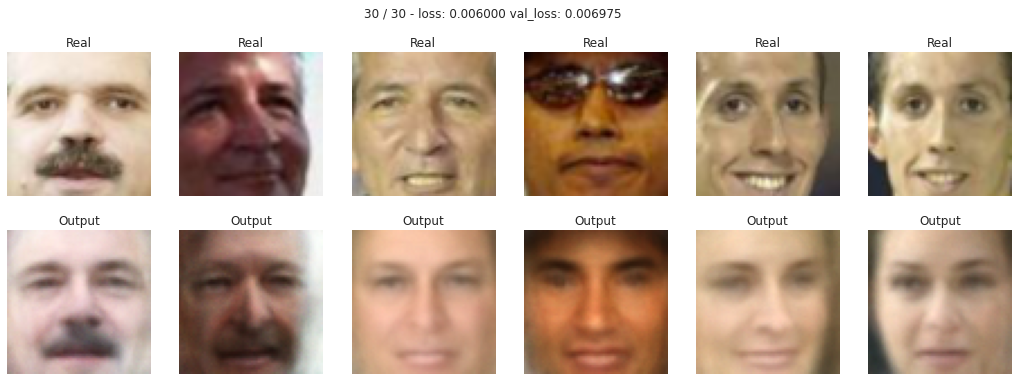

In [ ]:
history = (train(autoencoder, 
                 optimizer, 
                 criterion, 30, 128, 
                 X_train, 
                 X_val, 
                 conv=False)
)

In [ ]:
torch.save(autoencoder.state_dict(), 'LinearVanilla')

Мы видим, что кодировщик долго обучается, не так внимателен к деталям: усы еле заметны, очки, улыбки - передано положение лица и оттенок кожи персоны

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

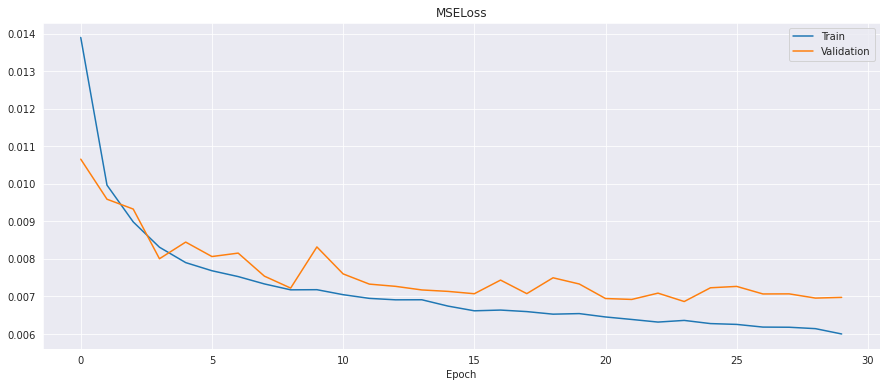

In [ ]:
train_losses, val_losses = zip(*history)

plt.figure(figsize=(15, 6))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('MSELoss')
plt.legend()
plt.show()

Модель немного переобучена. Проверим работу сверточного кодировщика без линейного слоя

In [ ]:
criterion = nn.MSELoss()
autoencoder_conv = Autoencoder_Conv().to(device)
optimizer = torch.optim.Adam(autoencoder_conv.parameters(), lr=1e-3)

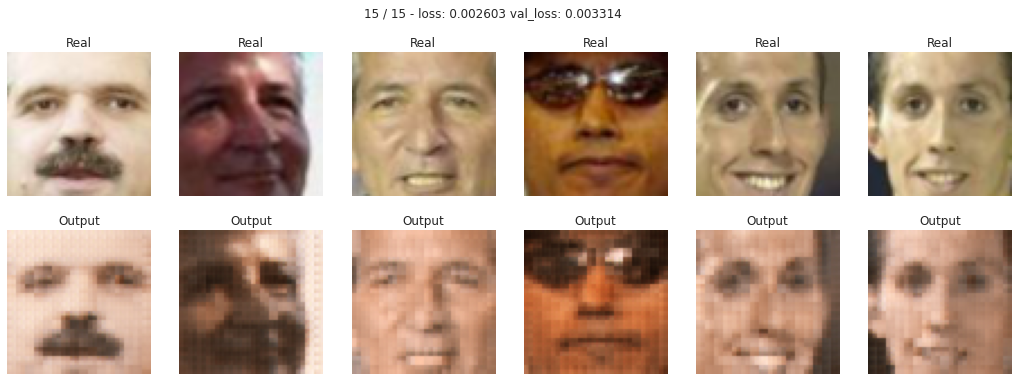

In [ ]:
history = (train(autoencoder_conv, 
                 optimizer, 
                 criterion, 15, 128, 
                 X_train, 
                 X_val, 
                 conv=True)
)

Здесь качество гораздо лучше - есть усы, аксессуары, переданы оттенки кожи, у людей есть улыбка. На выходе изображение теряет  качестве - попробуем сеть с большим количеством карт

In [ ]:
torch.save(autoencoder_conv.state_dict(), 'ConvVanilla')

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

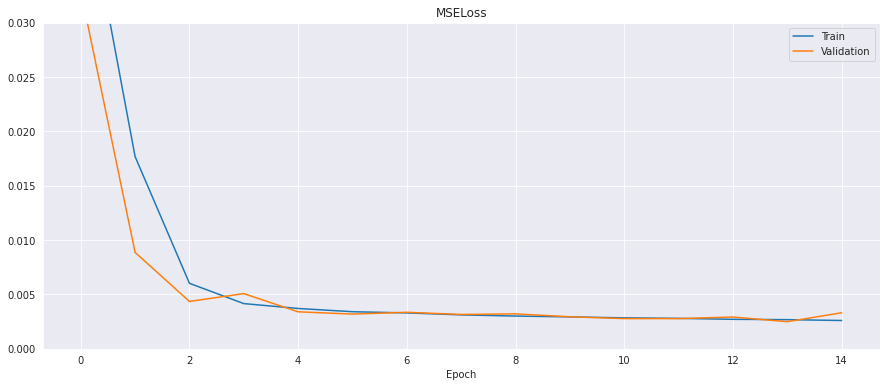

In [ ]:
train_losses, val_losses = zip(*history)

plt.figure(figsize=(15, 6))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.ylim([0, 0.03])
plt.xlabel('Epoch')
plt.title('MSELoss')
plt.legend()
plt.show()

Здесь с обобщением достаточно неплохо. Также попробуем сверточный автокодировщик с линейным

---
    
 <font size="2"> Изначально обучались на 50 эпохах. При повторном запуске, когда добавили функцию `sample`, снизили до 15, так как для этой архитектуры 50 эпох - избыточно. </font>

In [ ]:
criterion = nn.MSELoss()
autoencoder_conv_flatten = Autoencoder_Conv_Flatten().to(device)
optimizer = torch.optim.Adam(autoencoder_conv_flatten.parameters(), lr=1e-3)

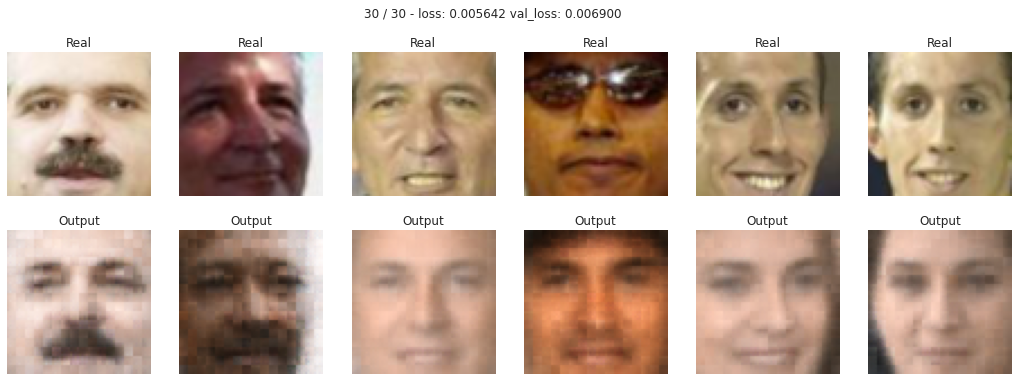

In [ ]:
history = (train(autoencoder_conv_flatten, 
                 optimizer, 
                 criterion, 30, 128, 
                 X_train, 
                 X_val, 
                 conv=True)
)

Здесь также восстановлены детали, качество лучше, чем у просто линейной сети но хуже, чем у сверточной сети без линейного слоя

In [ ]:
torch.save(autoencoder_conv_flatten.state_dict(), 'Conv_flattenVanilla')

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

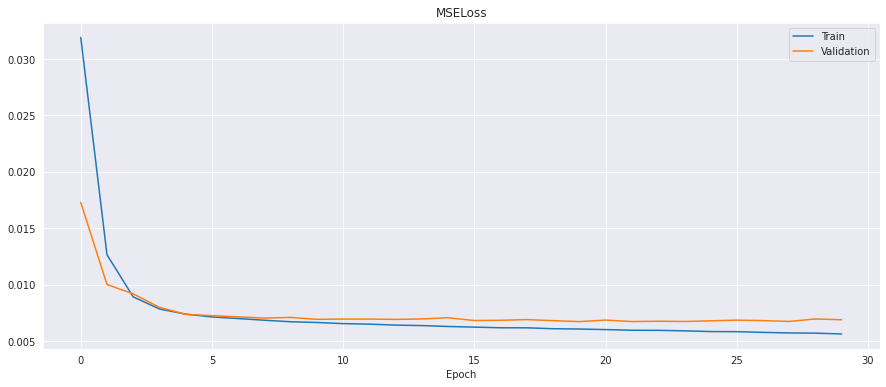

In [ ]:
train_losses, val_losses = zip(*history)

plt.figure(figsize=(15, 6))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.title('MSELoss')
plt.legend()
plt.show()

Модель хорошо обобщается, но качество хуже, чем у просто сверточной или линейной модели

___


Остановим свой выбор на линейной модели автокодировщика. Сверточной модели с `Flatten` слоем - также попробуем передать случайно созданный образец

## 1.4. Sampling 

Попробуем создать новое лицо, а не просто восстановленное из изображения, которое поступало в модель при обучении

Передадим в обученную сеть сгенерированный нами вектор:


---
    
 <font size="2"> Если вместо лиц выводится непонятное изображение, необходимо попробовать посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля случайности, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <sample dim>)`. А одно из требований, чтобы при предсказании случайного вектора получалось лицо - вектор должен быть распределен так же, как латентные векторы реальных изображений.  </font>





Для сверточной сети будем использовать `unifrom` распределение

```
Для загрузки Autoencoder_Conv() (без линейного слоя)
%%capture
!gdown 1WCRAXb3dTbEH_j_YzQRoQcD6rSdO6Uyc

autoencoder_conv = Autoencoder_Conv().to(device) 
autoencoder_conv.load_state_dict(torch.load('/content/ConvVanilla'))
dim_code = (4, 16, 16)
inputs = np.array([np.random.unifrom(0, 1, dim_code) for i in range(25)])

```


```
Для загрузки Autoencoder_Conv_Flatten() с линейным слоем и сигмоидой
%%capture
!gdown --id 12n-UEtxMUBxxaKW-gmsZJMtCQUC2HqcO
dim_code = 16
autoencoder_conv_flatten = Autoencoder_Conv_Flatten().to(device)
autoencoder_conv_flatten.load_state_dict(torch.load('/content/Conv_flattenVanilla'))

inputs = np.array([np.random.unifrom(0, 1, dim_code) for i in range(25)])
```

In [ ]:
%%capture
!gdown --id 12n-UEtxMUBxxaKW-gmsZJMtCQUC2HqcO
dim_code = 16
autoencoder_conv_flatten = Autoencoder_Conv_Flatten().to(device)
autoencoder_conv_flatten.load_state_dict(torch.load('/content/Conv_flattenVanilla'))

inputs = np.array([np.random.uniform(0, 1, dim_code) for i in range(25)])

In [ ]:
with torch.no_grad():
  autoencoder_conv_flatten.eval()
  output = (autoencoder_conv_flatten
            .decode(torch.FloatTensor(inputs))
            .to(device).permute(0, 2, 3, 1)
            )

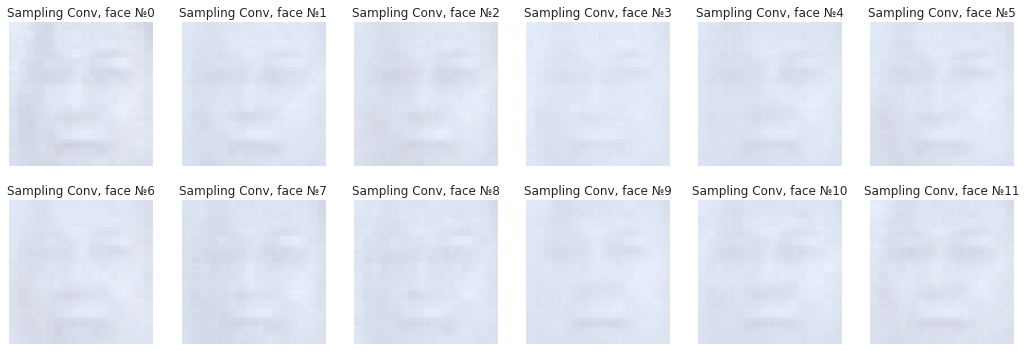

In [ ]:
plt.figure(figsize=(18, 6))
clear_output(wait=True)
for k in range(12):
    plt.subplot(2, 6, k+1)
    res = (output[k]
           .reshape(64, 64, 3)
           .cpu()
           .detach()
           .numpy()
           )
    res = res/np.amax(res)
    res = np.clip(res, 0, 1)
    plt.imshow(res, interpolation='nearest')
    plt.title(f'Sampling Conv, face №{k}')
    plt.axis('off')

Получили плохозаметные лица. Необходимо посмотреть латентное пространство и попробовать привести наш сампл к его распределению. Будем использовать `QuantileTransformer`

In [ ]:
latent_space = (get_latent_space(autoencoder_conv_flatten, X_val, 128, conv=True)
                    .cpu()
                    .detach()
                    .numpy()
)

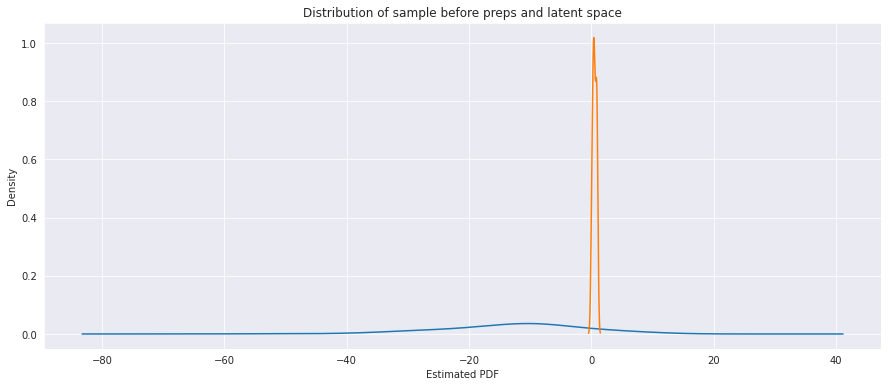

In [ ]:
plt.figure(figsize=(15, 6))
lat = pd.Series(latent_space[:, 1])
inp = pd.Series(inputs[:, 1])
lat.plot.kde()
inp.plot.kde()

plt.xlabel('Estimated PDF')
plt.title('Distribution of sample before preps and latent space')

plt.show()

Преобразуем образцы

In [ ]:
qt = QuantileTransformer(random_state=42)
lat_qt = (qt.fit_transform(latent_space).reshape(1, -1).T)[:,0]
new_inputs = (qt.inverse_transform(inputs).reshape(1, -1).T)[:,0]
new_inputs = new_inputs.reshape(-1, 16)

Посмотрим, что получили:

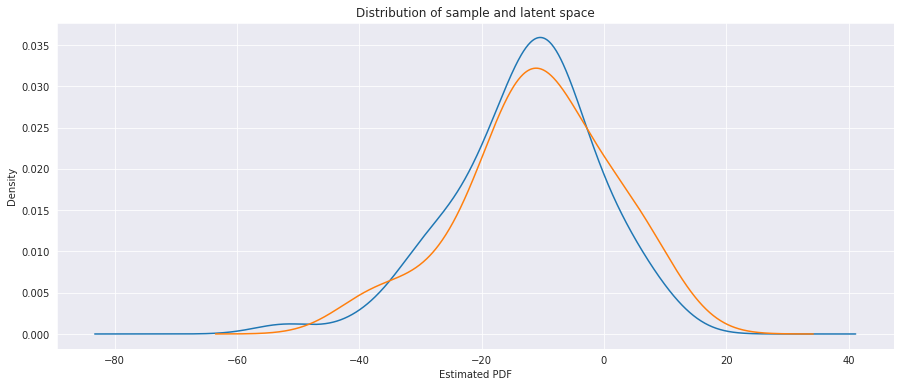

In [ ]:
plt.figure(figsize=(15, 6))
lat = pd.Series(latent_space[:, 1])
inp = pd.Series(new_inputs[:, 1])
lat.plot.kde()
inp.plot.kde()

plt.xlabel('Estimated PDF')
plt.title('Distribution of sample and latent space')

plt.show()

Попробуем теперь показать `sample` модели

In [ ]:
with torch.no_grad():
  autoencoder_conv_flatten.eval()
  output = autoencoder_conv_flatten.decode(torch.FloatTensor(new_inputs).to(device))

In [ ]:
with torch.no_grad():
  autoencoder_conv_flatten.eval()
  output = (autoencoder_conv_flatten
            .decode(torch.FloatTensor(new_inputs))
            .to(device).permute(0, 2, 3, 1)
            )

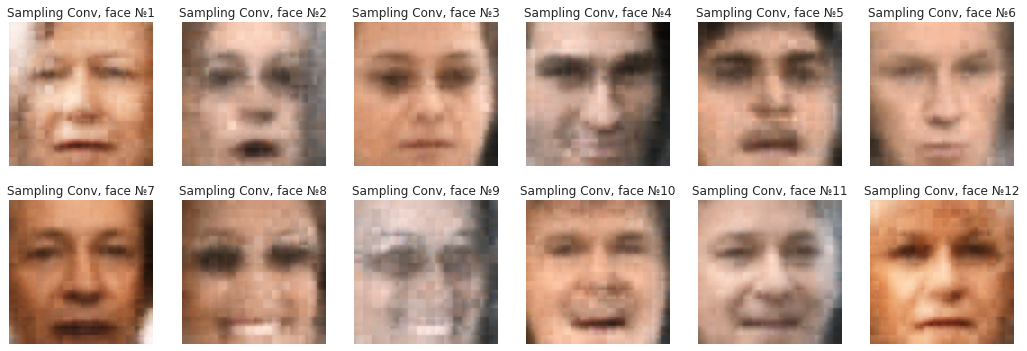

In [ ]:
plt.figure(figsize=(18, 6))
for k in range(12):
    plt.subplot(2, 6, k+1)
    res = (output[k]
           .reshape(64, 64, 3)
           .cpu()
           .detach()
           .numpy()
           )
    res = res/np.amax(res)
    res = np.clip(res, 0, 1)
    plt.imshow(res)
    
    plt.title(f'Sampling Conv, face №{k+1}')
    plt.axis('off')

Восстановили по вектору случайные лица  - посмотрим как с этим справится линейная модель

In [ ]:
dim_code = 16
inputs = np.array([np.random.normal(0, 1, dim_code) for i in range(25)])
inputs.shape

(25, 16)

In [ ]:
%%capture
!gdown --id 1q_EbwCaVFHmFXOpRQShY3raiEx8SyQ7L
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('/content/LinearVanilla'))

In [ ]:
with torch.no_grad():
  autoencoder.eval()
  output = autoencoder.sample(torch.FloatTensor(inputs).to(device))

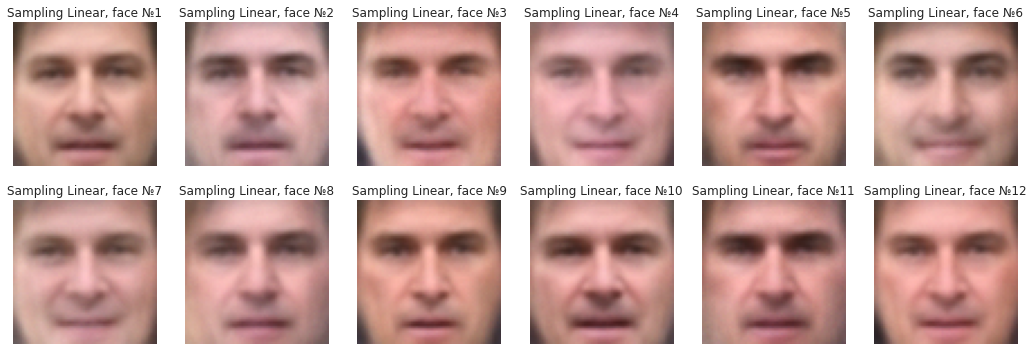

In [ ]:
plt.figure(figsize=(18, 6))
for k in range(12):
    plt.subplot(2, 6, k+1)
    res = output[k].cpu().detach().numpy()
    res = res/np.amax(res)
    res = np.clip(res, 0, 1)

    plt.imshow(res)
    plt.title(f'Sampling Linear, face №{k+1}')
    plt.axis('off')

Здесь также получили случайные лица

## 1.5. Трансформация изображений

Попробуем добавлять на изображения улыбки

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

1. Необходимо выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

2. Вычислить латентный вектор для всех улыбающихся людей, аналогично для грустных

3. Вычислить вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. Добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже с улыбкой

___

Работать будем с линейной моделью автокодировщика. Также, попробуем и на сверточной с линейным слоем



```
dim_code = 16

%%capture
!gdown --id 1q_EbwCaVFHmFXOpRQShY3raiEx8SyQ7L
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('/content/LinearVanilla'))

```

```
dim_code = 16

%%capture
!gdown --id 12n-UEtxMUBxxaKW-gmsZJMtCQUC2HqcO

autoencoder_conv_flatten = Autoencoder_Conv_Flatten().to(device)
autoencoder_conv_flatten.load_state_dict(torch.load('/content/Conv_flattenVanilla'))

```


In [ ]:
attrs.head()

Male     Asian  ... Wearing Necktie Wearing Necklace
0   1.56835  -1.88904  ...        0.694007        -0.826609
1  0.169851 -0.982408  ...         0.66676        -0.496559
2  0.997749  -1.36419  ...        0.144262        -0.841231
3   1.12272   -1.9978  ...        0.475941        -0.447025
4   1.07821   -2.0081  ...       -0.760774        -0.410152

[5 rows x 73 columns]

In [ ]:
smile_idx = (attrs['Smiling']
             .sort_values(ascending=False)
             .iloc[150:175]
             .index
             .values
             )
smile_data = data[smile_idx]

no_smile_idx = (attrs['Smiling']
                .sort_values(ascending=True)
                .iloc[150:175]
                .index
                .values
                )
no_smile_data = data[no_smile_idx]

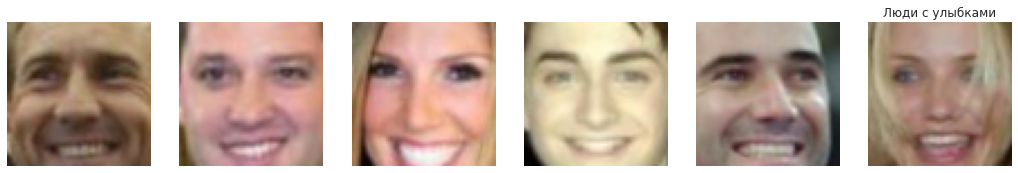

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(smile_data[i])
plt.title('Люди с улыбками')
plt.show();

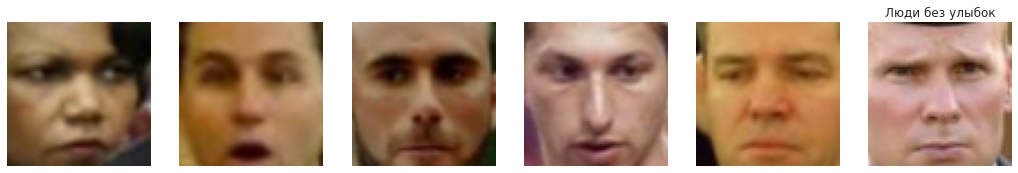

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(no_smile_data[i])
plt.title('Люди без улыбок')
plt.show();

In [ ]:
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('/content/LinearVanilla'))

<All keys matched successfully>

In [ ]:
def get_latent(model, img, conv=False):

    """
    Функция для получения латентного вектора для изображения или выборки
    изображений. Возвращает латентный вектор
    
    """
    with torch.no_grad():
        
        if conv == False:
          inputs = torch.FloatTensor(img.reshape(-1, 64 *64 * 3))
          inputs = inputs.to(device)
        else:
          inputs = torch.FloatTensor(img)
          inputs = inputs.to(device)
        model.eval()
        latent_space = model.encode(inputs)
        return latent_space

def get_reconstruction(model, latent_space, conv=False):
  
    """
    Функция для получения реконструкции изображения
    
    """
    with torch.no_grad():
        inputs = torch.FloatTensor(latent_space).to(device)
        model.eval()
        reconstruction = model.decode(inputs)
        if conv == False:
          reconstruction = reconstruction.view(-1, IMAGE_H * IMAGE_W * IN_CHANN)
        else:
          reconstruction = reconstruction.permute(0, 2, 3, 1)
        return reconstruction


def be_happy (model, data, idxs, smile_latent_vec, conv=False):

    """
    Функция для изменения изображения. На вход передается вектор разницы
    двух латентных векторов
    
    """

    X = torch.FloatTensor(data[idxs])
    transformed_data = data[idxs]
    latent = get_latent(model, transformed_data, conv=conv)

    for idx in range(len(latent)):
      latent[idx] += smile_latent_vec
    reconstruction = get_reconstruction(model, latent, conv=conv)
      
    clear_output(wait=True)
    plt.figure(figsize=(18, 6))

    for k in range(6):
      plt.subplot(2, 6, k+1)

      grt = X[k].cpu().detach().numpy()
      grt = grt/np.amax(grt)
      grt = np.clip(grt, 0, 1)

      plt.imshow(grt)
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      if conv == False:
        res = reconstruction[k].reshape(64, 64, 3).cpu().detach().numpy()
        res = res/np.amax(res)
        res = np.clip(res, 0, 1)
      else:
        res = reconstruction[k].cpu().detach().numpy()
        res = res/np.amax(res)
        res = np.clip(res, 0, 1)

      plt.imshow(res)
      plt.title('Output')
      plt.axis('off')
    plt.show()

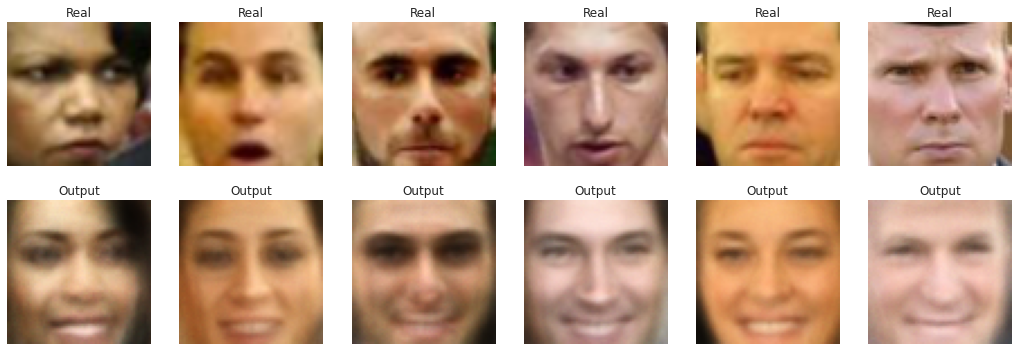

In [ ]:
smile_latent = get_latent(autoencoder, smile_data, conv=False).mean(axis=0)
no_smile_latent = get_latent(autoencoder, no_smile_data, conv=False).mean(axis=0)
smile_latent_vec = smile_latent - no_smile_latent

be_happy(autoencoder, data, no_smile_idx, smile_latent_vec, conv=False)

Удалось изменить изображение - на выходе получили улыбающихся людей. Посмотрим, как отработает сверточная сеть

In [ ]:
%%capture
!gdown --id 12n-UEtxMUBxxaKW-gmsZJMtCQUC2HqcO

autoencoder_conv_flatten = Autoencoder_Conv_Flatten().to(device)
autoencoder_conv_flatten.load_state_dict(torch.load('/content/Conv_flattenVanilla'))

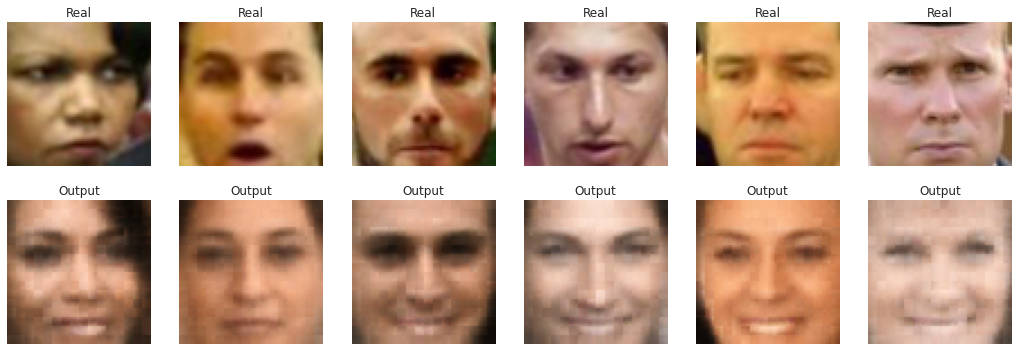

In [ ]:
smile_latent = get_latent(autoencoder_conv_flatten, smile_data, conv=True).mean(axis=0)
no_smile_latent = get_latent(autoencoder_conv_flatten, no_smile_data, conv=True).mean(axis=0)
smile_latent_vec = smile_latent - no_smile_latent

be_happy(autoencoder_conv_flatten, data, no_smile_idx, smile_latent_vec, conv=True)

Аналогичным обарзом, мы можем изменить любой атрибут, имеющийся в сете данных (`attr`)

___


Таким образом, построили и проверили три архитектуры простого автокодировщика, смогли предсказывать случайный вектор, а также изменили выходные изоображения, сравнив два латентных вектора

# Часть 2: Variational Autoencoder 

Займемся обучением вариационных автоэнкодеров. Обучать будем на датасете `MNIST`, содержащем написанные от руки цифры от `0` до `9`

In [ ]:
%%capture
batch_size = 128
train_dataset = (datasets
                 .MNIST(root='./mnist_data/', train=True, transform=transforms
                        .ToTensor(), download=True)
                 )
test_dataset = (datasets
                .MNIST(root='./mnist_data/', train=False, transform=transforms
                       .ToTensor(), download=False)
                )

train_loader = (torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True)
)
test_loader = (torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False)
)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## 2.1. VAE

### 2.1.1 Архитектура модели и обучение

Реализуем VAE. У энкодера сделаем две свертки с нормализацией, затем будет добавлен линейный слой. Далее у энкодера `Unflatten` слой и `ConTransposed2d` слои

In [ ]:
dim_code = 4

In [ ]:
class VAE(nn.Module):

    def __init__(self):
        super().__init__()
        # encoder

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()

        )

        self.flatten_mu = nn.Linear(128 * 7 * 7, out_features=dim_code)
        self.flatten_logsigma = nn.Linear(128 * 7 * 7, out_features=dim_code)

        # decoder

        self.decode_linear = nn.Linear(4, 128 * 7 * 7)
        self.decode_2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                                        kernel_size=4, stride=2, padding=1)
        self.decode_1 = nn.ConvTranspose2d(in_channels=64, out_channels=1, 
                                        kernel_size=4, stride=2, padding=1)




    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logsigma = self.flatten_mu(x), self.flatten_logsigma(x)
        z = self.gaussian_sampler(mu, logsigma)
        return z
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma / 2)
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu


    def decode(self, x):
        x = self.decode_linear(x)
        x = x.view(x.size(0), 128, 7, 7)
        x = F.relu(self.decode_2(x))
        reconstruction = F.sigmoid(self.decode_1(x))
        return reconstruction
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logsigma = self.flatten_mu(x), self.flatten_logsigma(x)
        z = self.gaussian_sampler(mu, logsigma)
        x = self.decode_linear(z)
        x = x.view(x.size(0), 128, 7, 7)
        x = F.relu(self.decode_2(x))
        reconstruction = F.sigmoid(self.decode_1(x))
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для `VAE`:

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных объектов
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
def train_epoch(model, criterion, optimizer, data_loader):
    """
    Функция для обучения модели - принимает модель, критерий, оптмиизатор,
    обучающий лоадер. Возвращает средний лосс, mu, сигму и восстановленное изображение
    
    """
    train_losses_per_epoch = []
    model.train()
    for x_batch, _ in data_loader:

        x_batch = x_batch.to(device)    
        mu, logsigma, reconstruction = model(x_batch)
        loss = criterion(x_batch.to(device).float(), mu, logsigma, reconstruction)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())

    return np.mean(train_losses_per_epoch), mu, logsigma, reconstruction

In [ ]:
def eval_epoch(model, criterion, optimizer, data_loader):
    """
    Функция для валидации модели - принимает модель, критерий, оптмиизатор,
    тестовый лоадер. Возвращает средний лосс, mu, сигму и восстановленное изображение
    
    """
    val_losses_per_epoch = []
    model.eval()
    with torch.no_grad():
        for x_val, _ in data_loader:
          x_val = x_val.to(device)
          mu, logsigma, reconstruction = model(x_val)
          loss = criterion(x_val.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())
    return np.mean(val_losses_per_epoch), mu, logsigma, reconstruction

In [ ]:
def plot_output(model, epoch, epochs, train_loss, val_loss, size = 5):
    """
    Функция для отрисовки изображений после обучения
    
    """

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
    for k in range(size):
      ax = plt.subplot(2, size, k + 1)
      img = test_dataset[k][0].unsqueeze(0).to(device)

      model.eval()
      with torch.no_grad():
         mu, logsigma, reconstruction  = model(img)

      plt.imshow(img.squeeze().numpy(), cmap='gray')
      plt.axis('off')
      if k == size//2:
        ax.set_title('Real')
      ax = plt.subplot(2, size, k + 1 + size)
      plt.imshow(reconstruction.squeeze().numpy(), cmap='gray')
      plt.axis('off')

      if k == size//2:
         ax.set_title('Output')
    plt.suptitle('%d / %d - loss: %f val_loss: %f' % (epoch+1, epochs, train_loss, val_loss))
    plt.show()

И обучим модель на 15 эпохах:

In [ ]:
criterion = loss_vae
autoencoder_vae = VAE()
optimizer = torch.optim.Adam(autoencoder_vae.parameters(), lr=1e-3)

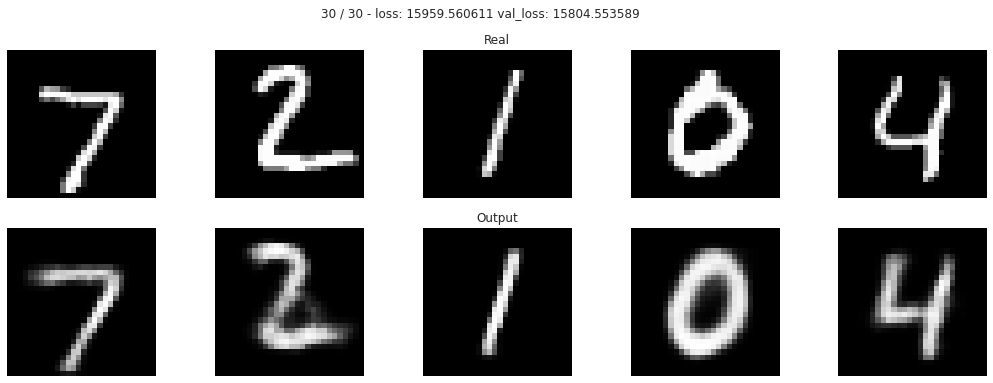

In [ ]:
epochs = 30
loss = {'train_loss':[],'val_loss':[]}
with tqdm(desc="epoch", total=epochs) as pbar_outer:
  for epoch in range(epochs):
      print('* Epoch %d/%d' % (epoch+1, epochs))
      train_loss, mu, logsigma, reconstruction = (train_epoch(autoencoder_vae, 
                                                             criterion, 
                                                             optimizer, 
                                                             train_loader
                                                             )
      )

      val_loss, mu, logsigma, reconstruction = (eval_epoch(autoencoder_vae, 
                                                          criterion, 
                                                          optimizer, 
                                                          test_loader)
      )
      pbar_outer.update(1)
      
      loss['train_loss'].append(train_loss)
      loss['val_loss'].append(val_loss)
      plot_output(autoencoder_vae, epoch, epochs, train_loss, val_loss, size = 5)

Сохраним модель, если потребуется перезапускать код. 

In [ ]:
torch.save(autoencoder_vae.state_dict(), 'GaussianVAE_30')

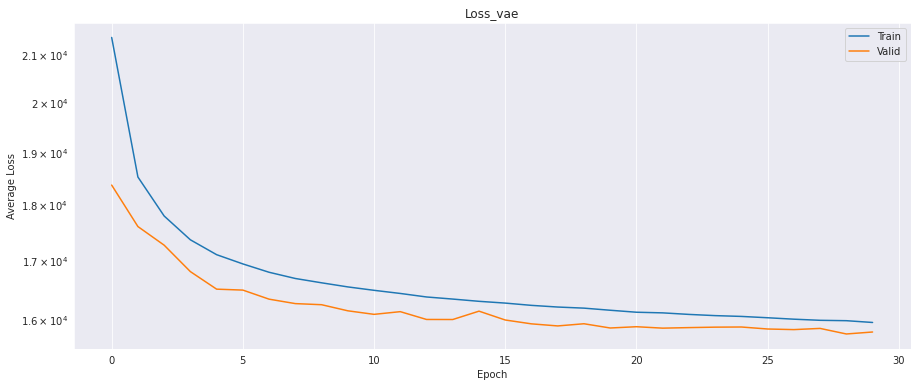

In [ ]:
plt.figure(figsize=(15, 6))
plt.semilogy(loss['train_loss'], label='Train')
plt.semilogy(loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Loss_vae')
plt.show()

Попробуем для `VAE` то же, что и с обычным автоэнкодером -- показать `decoder` из `VAE` случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

```
Для загрузки VAE, обученной на 15 эпохах

%%capture
!gdown --id 1WNjoaYxUD3sTGxiJXe-WlpuxuP7HA-YG
autoencoder_vae = VAE()
autoencoder_vae.load_state_dict(torch.load('/content/GaussianVAE'))

____________________________________________________________________________

Для загрузки VAE, обученной на 30 эпохах

%%capture
!gdown --id 1tH-uo3Prf75GqnSU-Q3ez_bpJymVIjNF
autoencoder_vae = VAE()
autoencoder_vae.load_state_dict(torch.load('/content/GaussianVAE_30'))

```

In [ ]:
%%capture
!gdown --id 1tH-uo3Prf75GqnSU-Q3ez_bpJymVIjNF
autoencoder_vae = VAE()
autoencoder_vae.load_state_dict(torch.load('/content/GaussianVAE_30'))

In [ ]:
inputs = np.array([np.random.normal(0, 1, 4) for i in range(12)])

In [ ]:
with torch.no_grad():
  autoencoder_vae.eval()
  output = autoencoder_vae.decode(torch.FloatTensor(inputs).to(device))

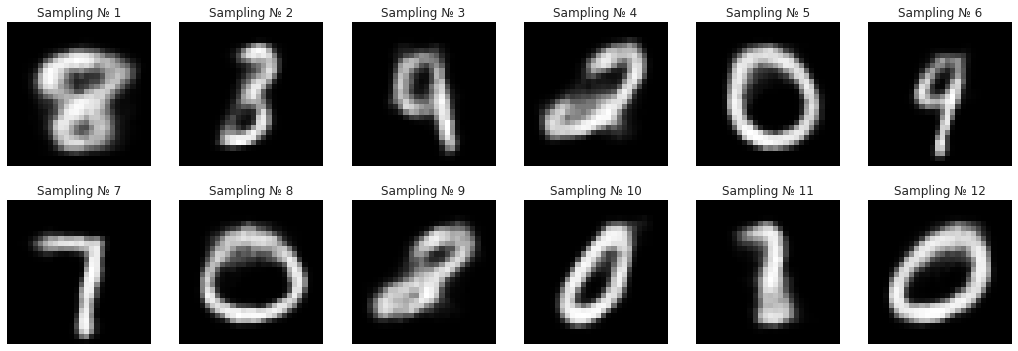

In [ ]:
plt.figure(figsize=(18, 6))
for k in range(12):
    plt.subplot(2, 6, k+1)
    res = output[k].cpu().squeeze().detach().numpy()
    plt.imshow(res, cmap='gray')
    plt.title(f'Sampling № {k + 1}')
    plt.axis('off')

Довольно неплохо. Сеть отрисовывает рукописные цифры

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


<a id='early'></a>

### 2.1.2. Latent Representation

Давайте посмотрим, как латентные векторы выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `plotly.express`/[документация](https://plotly.com/python-api-reference/generated/plotly.express.scatter), покрасить разными цветами точки, соответствующие картинкам разных цифр.

Но перед тем, как изобразить `t-SNE` представление - попробуем изобразить латентное пространство без `t-SNE` для сравнения. Для того, чтобы отобразить цифры по цветам - нам необходимы метки, поэтому соберем `DataFrame` из латентного пространства и меток, обозначающих ту или иную цифру - используя **СТРОГО** `test_dataset`

In [ ]:
latent_space = []
for digits in tqdm(test_dataset):
    img = digits[0].unsqueeze(0).to(device)
    label = digits[1]

    autoencoder_vae.eval()
    with torch.no_grad():
        latent = autoencoder_vae.encode(img)

    latent = latent.flatten().cpu().numpy()
    sample = {f"Encoded_{i}": encoded for i, encoded in enumerate(latent)}
    sample['label'] = label
    latent_space.append(sample)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
latent_space = pd.DataFrame(latent_space)
latent_space['label'] = latent_space['label'].astype(str)

In [ ]:
latent_space.head()

Encoded_0  Encoded_1  Encoded_2  Encoded_3 label
0   2.544198  -1.312107   0.713362  -1.061693     7
1  -0.509725   0.863112  -0.319793  -2.933067     2
2  -0.988468  -2.389496   0.227045  -0.904020     1
3  -0.309697   1.084858  -0.470303   0.921662     0
4   1.249683   0.355911   1.495609   1.467608     4

In [ ]:
fig = px.scatter(latent_space, x='Encoded_0', y='Encoded_1', 
           color='label', opacity=0.42,
           
                 labels={
                     'label': "Цифра "
                 },
                title="Отображение латентного простраства без t-SNE")\
                .for_each_trace(lambda t: t.update(name=t.name.replace("=",": "))
                )
           
           

fig.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                selector=dict(mode='markers'))
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(visible=False, showticklabels=False)
fig.show();

В таком случае, множество цифр попадает в один кластер. Попробуем применить `t-SNE` и сравним разницу

In [ ]:
tsne = TSNE(n_components=2)
digits_embedded = tsne.fit_transform(latent_space.drop(['label'],axis=1))

In [ ]:
digits_embedded[:5]

array([[ -2.404626,  51.963165],
       [-26.170433, -10.898435],
       [-33.80795 ,  59.074394],
       [-32.958347, -50.060787],
       [ 71.1217  ,  28.541605]], dtype=float32)

In [ ]:
fig = px.scatter(digits_embedded, x=0, y=1, 
           color=latent_space['label'], opacity=0.7,
           
                 labels={
                     'color': "Цифра "
                 },
                title="Отображение латентного простраства с t-SNE")\
                .for_each_trace(lambda t: t.update(name=t.name.replace("=",": "))
                )
           
           

fig.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                selector=dict(mode='markers'))
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(visible=False, showticklabels=False)
fig.show();

`t-SNE` представление позволяет отделить одну цифру от другой. Некоторые точки пересекаются, но тем не мнее - лучше чем обычное представление - мы наблюдаем группы точек

## 2.2. Conditional VAE


К нашему `VAE` добавим функцию `выдавать мне рандомное число из вот этого вот класса`, где классов десять (цифры от 0 до 9 образуют десять классов).  `Conditional VAE` — так называется вид автоэнкодера, который предоставляет такую возможность.

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### 2.2.1. Архитектура

на изображении снизу представлена архитектура простого `Conditional VAE`.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

In [ ]:
dim_code = 4

In [ ]:
class cVAE(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder

        self.label = nn.Embedding(10, dim_code)

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()

        )

        self.flatten_mu = nn.Linear(128 * 7 * 7, out_features=dim_code)
        self.flatten_logsigma = nn.Linear(128 * 7 * 7, out_features=dim_code)

        # decoder

        self.decode_linear = nn.Linear(8, 128 * 7 * 7)
        self.decode_2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                                        kernel_size=4, stride=2, padding=1)
        self.decode_1 = nn.ConvTranspose2d(in_channels=64, out_channels=1, 
                                        kernel_size=4, stride=2, padding=1)




    def encode(self, x, y):
        y = self.label(y)
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logsigma = self.flatten_mu(x), self.flatten_logsigma(x)
        x = self.gaussian_sampler(mu, logsigma)
        z = torch.cat((x, y), dim = 1)
        return z
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma / 2)
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu


    def decode(self, x, y):
        y = self.label(y)
        z = torch.cat((x, y), dim = 1)
        x = self.decode_linear(z)
        x = x.view(x.size(0), 128, 7, 7)
        x = F.relu(self.decode_2(x))
        reconstruction = F.sigmoid(self.decode_1(x))
        return reconstruction
    
    def forward(self, x, y):
        y = self.label(y)
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logsigma = self.flatten_mu(x), self.flatten_logsigma(x)
        x = self.gaussian_sampler(mu, logsigma)
        z = torch.cat((x, y), dim = 1)
        x = self.decode_linear(z)
        x = x.view(x.size(0), 128, 7, 7)
        x = F.relu(self.decode_2(x))
        reconstruction = F.sigmoid(self.decode_1(x))
        return mu, logsigma, reconstruction

Немного изменим функции для обучения - нам надо передавать информацию о значении целевой переменной для объекта


In [ ]:
def train_epoch_cvae(model, criterion, optimizer, data_loader):
    """
    Функция для обучения модели - принимает модель, критерий, оптмиизатор,
    обучающий лоадер. Возвращает средний лосс, mu, сигму и восстановленное изображение
    
    """
    train_losses_per_epoch = []
    model.train()
    for x_batch, y in data_loader:
        y = y.to(device)
        x_batch = x_batch.to(device)    
        mu, logsigma, reconstruction = model(x_batch, y)
        loss = criterion(x_batch.to(device).float(), mu, logsigma, reconstruction)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())

    return np.mean(train_losses_per_epoch), mu, logsigma, reconstruction

In [ ]:
def eval_epoch_cvae(model, criterion, optimizer, data_loader):
    """
    Функция для валидации модели - принимает модель, критерий, оптмиизатор,
    тестовый лоадер. Возвращает средний лосс, mu, сигму и восстановленное изображение
    
    """
    val_losses_per_epoch = []
    model.eval()
    with torch.no_grad():
        for x_val, y in data_loader:
          y = y.to(device)
          x_val = x_val.to(device)
          mu, logsigma, reconstruction = model(x_val, y)
          loss = criterion(x_val.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())
    return np.mean(val_losses_per_epoch), mu, logsigma, reconstruction

In [ ]:
def plot_output_cvae(model, epoch, epochs, train_loss, val_loss, size = 5):
    """
    Функция для отрисовки изображений после обучения
    
    """

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
    for k in range(size):
      ax = plt.subplot(2, size, k + 1)
      img, label = next(iter(test_loader))
      img = img.to(device)
      label = label.to(device)
      model.eval()
      with torch.no_grad():
         mu, logsigma, reconstruction  = model(img, label)

      plt.imshow(img[k].squeeze().numpy(), cmap='gray')
      plt.axis('off')
      plt.title(f'Real Значение {label[k].item()}')
      ax = plt.subplot(2, size, k + 1 + size)
      plt.imshow(reconstruction[k].squeeze().numpy(), cmap='gray')
      plt.axis('off')

      if k == size//2:
         ax.set_title('Output')
    plt.suptitle('%d / %d - loss: %f val_loss: %f' % (epoch+1, epochs, train_loss, val_loss))
    plt.show()

In [ ]:
criterion = loss_vae
autoencoder_cvae = cVAE()
optimizer = torch.optim.Adam(autoencoder_cvae.parameters(), lr=1e-3)

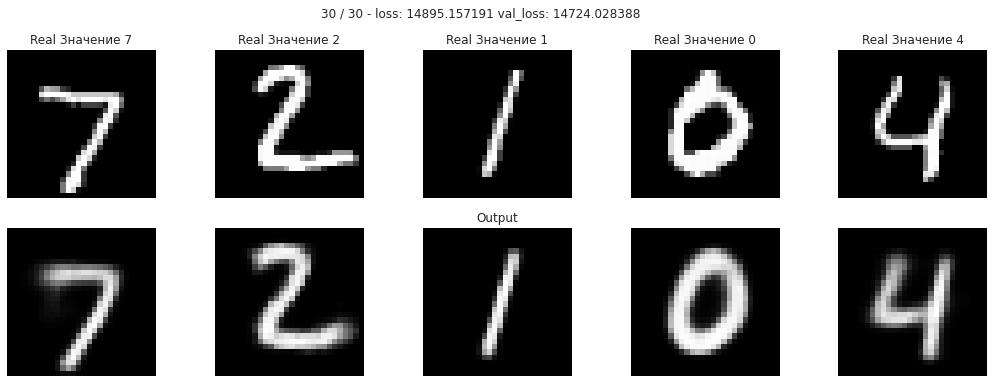

In [ ]:
epochs = 30
loss = {'train_loss':[],'val_loss':[]}
with tqdm(desc="epoch", total=epochs) as pbar_outer:
  for epoch in range(epochs):
      print('* Epoch %d/%d' % (epoch+1, epochs))
      train_loss, mu, logsigma, reconstruction = (train_epoch_cvae(autoencoder_cvae, 
                                                             criterion, 
                                                             optimizer, 
                                                             train_loader
                                                             )
      )

      val_loss, mu, logsigma, reconstruction = (eval_epoch_cvae(autoencoder_cvae, 
                                                          criterion, 
                                                          optimizer, 
                                                          test_loader)
      )
      pbar_outer.update(1)
      
      loss['train_loss'].append(train_loss)
      loss['val_loss'].append(val_loss)
      plot_output_cvae(autoencoder_cvae, epoch, epochs, train_loss, val_loss, size = 5)

Модель лучше обущается, лосс меньше, посмотрим кривые обучения

In [ ]:
torch.save(autoencoder_cvae.state_dict(), 'Gaussian_cVAE')

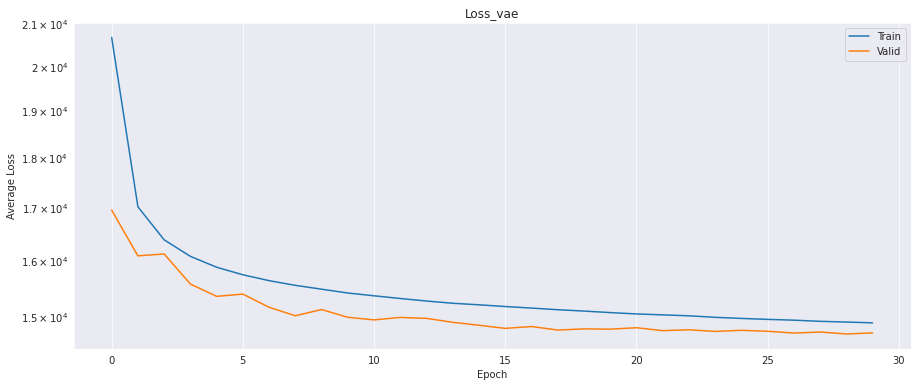

In [ ]:
plt.figure(figsize=(15, 6))
plt.semilogy(loss['train_loss'], label='Train')
plt.semilogy(loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Loss_vae')
plt.show()

In [ ]:
%%capture
!gdown --id 1M-ecoRci79Iwloh9PYep5ja2mQHEz8YL
autoencoder_cvae = cVAE()
autoencoder_cvae.load_state_dict(torch.load('/content/Gaussian_cVAE'))

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### 2.2.2. Sampling


Попробуем сэмплировать из `cVAE`. Можно взять один и тот же латентный вектор и попросить `cVAE` восстановить из него картинки разных классов
Для `MNIST` мы можете попросить `cVAE` восстановить из одного латентного вектора, например, картинки цифры `4` и `2`.

```
Для загрузки cVae

%%capture
!gdown --id 1M-ecoRci79Iwloh9PYep5ja2mQHEz8YL
autoencoder_cvae = cVAE()
autoencoder_cvae.load_state_dict(torch.load('/content/Gaussian_cVAE'))

```

In [ ]:
inputs = np.array([np.random.normal(0, 1, dim_code) for i in range(12)])
label_4 = np.array([4 for i in range(12)])
label_2 = np.array([2 for i in range(12)])

In [ ]:
with torch.no_grad():
  autoencoder_cvae.eval()
  output = autoencoder_cvae.decode(torch.FloatTensor(inputs).to(device), 
                                   torch.IntTensor(label_4).to(device)
                                   )

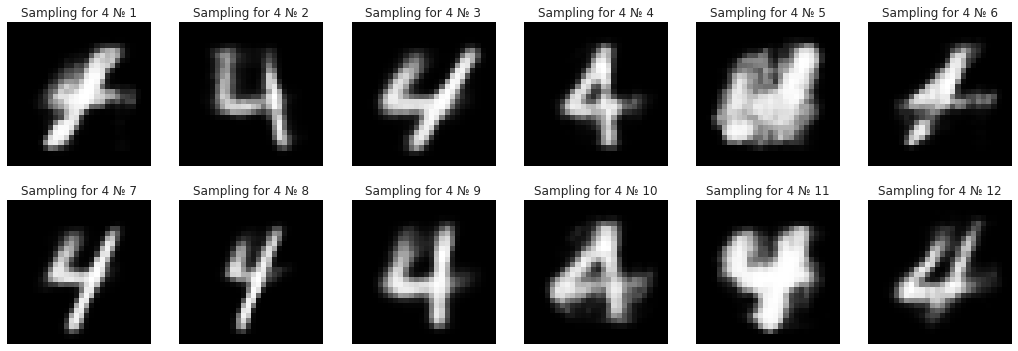

In [ ]:
plt.figure(figsize=(18, 6))
for k in range(12):
    plt.subplot(2, 6, k+1)
    res = output[k].cpu().squeeze().detach().numpy()
    plt.imshow(res, cmap='gray')
    plt.title(f'Sampling for 4 № {k + 1}')
    plt.axis('off')

Теперь для цифры `2`

In [ ]:
with torch.no_grad():
  autoencoder_cvae.eval()
  output = autoencoder_cvae.decode(torch.FloatTensor(inputs).to(device), 
                                   torch.IntTensor(label_2).to(device)
                                   )

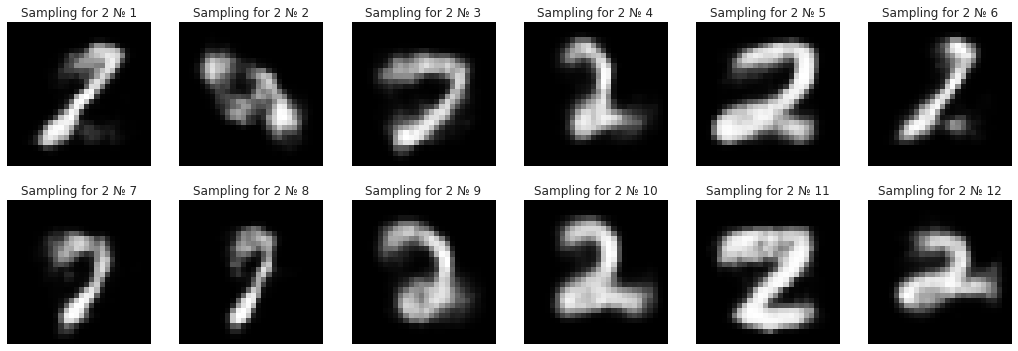

In [ ]:
plt.figure(figsize=(18, 6))
for k in range(12):
    plt.subplot(2, 6, k+1)
    res = output[k].cpu().squeeze().detach().numpy()
    plt.imshow(res, cmap='gray')
    plt.title(f'Sampling for 2 № {k + 1}')
    plt.axis('off')

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### 2.3.2. Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в `cVAE` ([ранее](#early) мы делали это для `VAE`)



In [ ]:
%%capture
!gdown --id 1M-ecoRci79Iwloh9PYep5ja2mQHEz8YL
autoencoder_cvae = cVAE()
autoencoder_cvae.load_state_dict(torch.load('/content/Gaussian_cVAE'))

In [ ]:
latent_space = []

test_loader = (torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=1, 
                                           shuffle=False)
)
for X, y in tqdm(test_loader):
  img = X.to(device)
  label = y.to(device)
  autoencoder_cvae.eval()
  with torch.no_grad():
      latent = autoencoder_cvae.encode(img, label)

  latent = latent.flatten().cpu().numpy()
  sample = {f"Encoded_{i}": encoded for i, encoded in enumerate(latent)}
  sample['label'] = label.item()
  latent_space.append(sample)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
latent_space = pd.DataFrame(latent_space)
latent_space['label'] = latent_space['label'].astype(str)

In [ ]:
latent_space.head()

Encoded_0  Encoded_1  Encoded_2  ...  Encoded_6  Encoded_7  label
0   0.578438   0.016646  -0.326312  ...   1.597500   0.426077      7
1  -0.715285  -0.015610   0.540476  ...   2.086053  -0.020881      2
2   1.887095  -0.093572   1.525883  ...   0.940374  -0.881294      1
3  -0.353677  -0.376808  -0.334562  ...  -0.583349  -1.334335      0
4  -0.175043   0.814517  -1.252478  ...   0.781999  -0.315660      4

[5 rows x 9 columns]

Отличается на 4 признака от того, что мы получали на `VAE` - это связано с тем, что мы кодируем еще целевую переменную. Уверен, что в таком случае `t-SNE` должен получиться практически идеальным

In [ ]:
fig = px.scatter(latent_space, x='Encoded_0', y='Encoded_1', 
           color='label', opacity=0.42,
           
                 labels={
                     'label': "Цифра "
                 },
                title="Отображение латентного простраства без t-SNE")\
                .for_each_trace(lambda t: t.update(name=t.name.replace("=",": "))
                )
           
           

fig.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                selector=dict(mode='markers'))
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(visible=False, showticklabels=False)
fig.show();

Без `t-SNE` разницы особой не видно - попробуем сделать с `t-SNE`

In [ ]:
tsne = TSNE(n_components=2)
digits_embedded = tsne.fit_transform(latent_space.drop(['label'],axis=1))

In [ ]:
digits_embedded[:5]

array([[ 40.099525, -40.22957 ],
       [-42.32428 ,  21.835896],
       [  7.082507,  -1.816621],
       [-32.762306, -31.679989],
       [ 41.178135,  50.988384]], dtype=float32)

In [ ]:
fig = px.scatter(digits_embedded, x=0, y=1, 
           color=latent_space['label'], opacity=0.7,
           
                 labels={
                     'color': "Цифра "
                 },
                title="Отображение латентного простраства с t-SNE")\
                .for_each_trace(lambda t: t.update(name=t.name.replace("=",": "))
                )
           
           

fig.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                selector=dict(mode='markers'))
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(visible=False, showticklabels=False)
fig.show();

Цифры отделены идеально - наблюдаем уже четкие кластеры, по сравнению с `VAE` - это связано с тем, что в латентном пространстве содержится информация о целевой переменной (`Encoded_4:Encoded_7`) - `data leaks`

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


# Denoising

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. 

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (`denoising`). Для этого их нужно обучить специальным образом: `input` картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, `loss-функция` AE останется той же (`MSE` между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Сделаем копию сета с лицами и добавим шум

In [ ]:
noise_factor = 0.5
X_noisy_train = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_noisy_val = X_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_val.shape) 

In [ ]:
X_noisy_train = torch.FloatTensor(X_noisy_train)
X_noisy_val = torch.FloatTensor(X_noisy_val)

Загрузим ранее подготовленный Автокодировщик со сверточными и линейными слоями и обучим его заново

In [ ]:
criterion = nn.MSELoss()
autoencoder_conv_flatten = Autoencoder_Conv_Flatten().to(device)
optimizer = torch.optim.Adam(autoencoder_conv_flatten.parameters(), lr=1e-3)

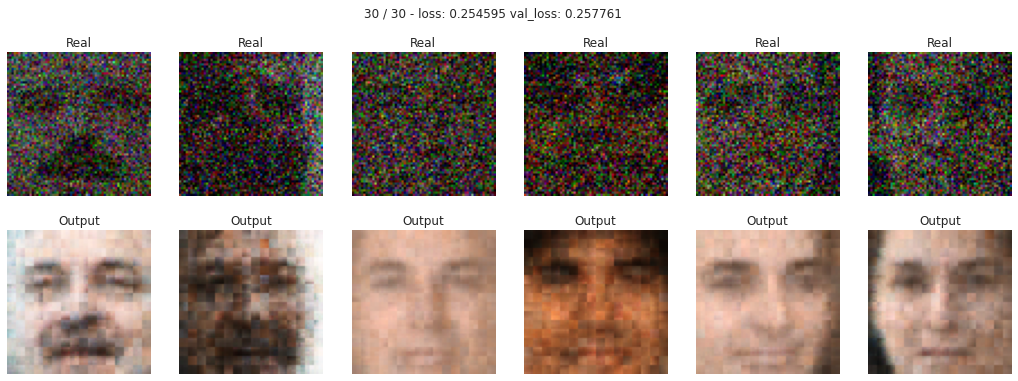

In [ ]:
history = (train(autoencoder_conv_flatten, 
                 optimizer, 
                 criterion, 30, 128, 
                 X_noisy_train, 
                 X_noisy_val, 
                 conv=True)
)

In [ ]:
torch.save(autoencoder_conv_flatten.state_dict(), 'ConvVanilla_noisy')

```
dim_code = 16

%%capture
!gdown --id 1PWNeyJ8ZOxhqYRtV3WDjG1O7RkPGRbYd

autoencoder_conv_flatten = Autoencoder_Conv_Flatten().to(device)
autoencoder_conv_flatten.load_state_dict(torch.load('/content/ConvVanilla_noisy'))

```

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

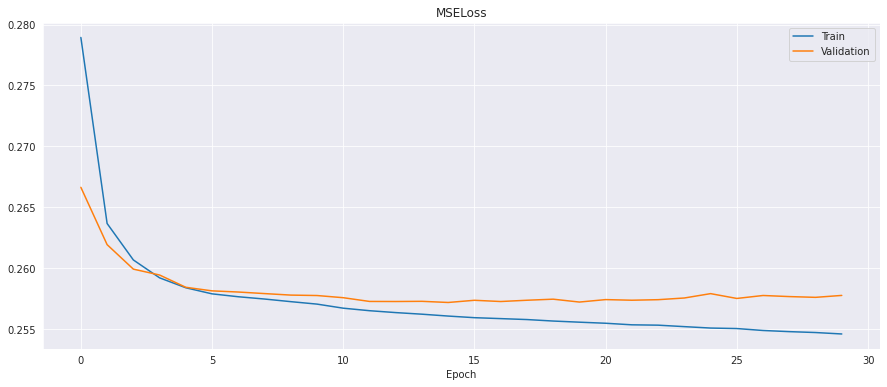

In [ ]:
train_losses, val_losses = zip(*history)

plt.figure(figsize=(15, 6))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.title('MSELoss')
plt.legend()
plt.show()

Немного переобучились, но при этом - достаточно хорошие рузльтаты - шум убрали

# Image Retrieval

Если представить, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения  и хотим понять, что это за человек. С помощью VAE, кодируем картинку в латентное представление и ищем среди латентные представлений лиц нашей базы самые ближайшие

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`. Возьмем `NearestNeighbors` - `LSHF` убрали из `sklearn`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного `NearestNeighbors` ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления

In [ ]:
dim_code = 16

!gdown --id 1q_EbwCaVFHmFXOpRQShY3raiEx8SyQ7L
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('/content/LinearVanilla'))

Downloading...
From: https://drive.google.com/uc?id=1q_EbwCaVFHmFXOpRQShY3raiEx8SyQ7L
To: /content/LinearVanilla
100% 105M/105M [00:00<00:00, 171MB/s] 


<All keys matched successfully>

In [ ]:
def get_similar(image, n_neighbors=5):
  """
  функция, которая берет тестовый image и с помощью метода kneighbours у NearestNeighbors ищет ближайшие векторы
  прогоняет векторы через декодер и получает картинки ближайших людей

  """
  latent_space = []
  train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)
  autoencoder.eval()
  with torch.no_grad():
    for batch in train_loader:
      batch = batch.view(-1, 64 * 64 * 3).to(device)
      latent = autoencoder.encode(batch)
      latent = latent.flatten().cpu().numpy()
      sample = {f"Encoded_{i}": encoded for i, encoded in enumerate(latent)}
      latent_space.append(sample)
  latent_space = pd.DataFrame(latent_space)
  neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=.2).fit(latent_space)
  image = autoencoder.encode(image.view(-1, 64 * 64 * 3)).flatten().cpu().detach().numpy()
  (distances,),(idx,) = neigh.kneighbors([image], n_neighbors=n_neighbors)
  
  return distances, X_train[idx]

In [ ]:
def show_similar(image):

    """
    функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    """
    distances, neighbors = get_similar(image, n_neighbors=11)

    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 4, 1)
    plt.imshow(image.cpu().numpy())
    plt.title("Original image")
    plt.axis('off')
    for i in range(11):
        plt.subplot(3, 4, i+2)
        plt.imshow(neighbors[i].cpu().numpy())
        plt.title("Dist=%.3f"%distances[i])
        plt.axis('off')
    plt.show()

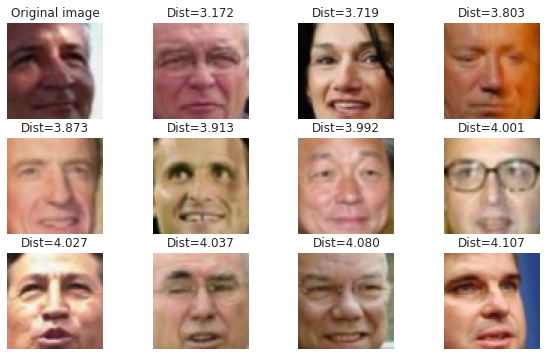

In [ ]:
image = X_val[1]
show_similar(image)

Удалось найти похожие лица в сете